In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### ***Dataset Exploration***

In [2]:
data = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
data

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [3]:
# labels in the dataset
classes = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger',
}

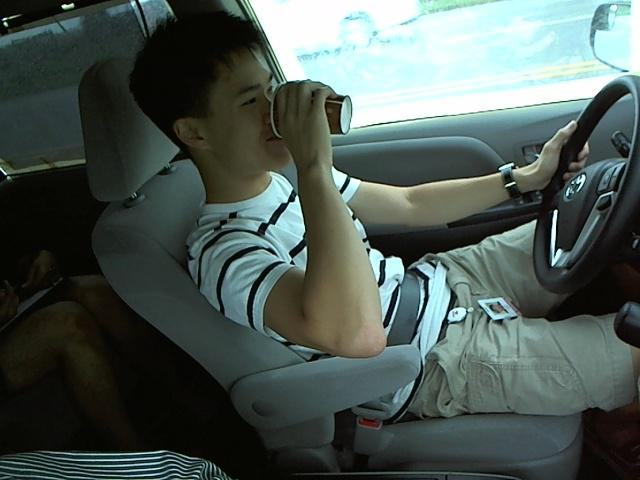

drinking


In [4]:
# visualizing dataset images and its corresponding label
from IPython.display import display, Image
data_image_index = 500
display(Image(filename='/kaggle/input/state-farm-distracted-driver-detection/imgs/train/'+list(data['classname'])[data_image_index]+'/'+list(data['img'])[data_image_index]))
print(classes[list(data['classname'])[data_image_index]])

In [5]:
# required tensorflow keras libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3

### ***Model Architecture***
***To build the model, I decided to use popular 'Transfer Learning' Technique. So, while searching about it, I came across '[EfficientNet - Rethinking Model Scaling for Convolutional Neural Networks](http://proceedings.mlr.press/v97/tan19a/tan19a.pdf) Research Paper ( which currently is the state-of-the-art model for CNN )'.***

***And in this, I attached Global Average Pooling too as by default it has a fully connected layer at the top of the network and I just wanna use it for feature extraction.***

***Next, I added few more layers:***
* ***Batch Normalization Layer - so that pretrained weights of EfficientNetB3 on 'imagenet' won't suffer from covariant shift plus it speedsup the model training***
* ***Dropout Layer - for Regularization purpose while training***
* ***Dense Layer - output layer of 10 units with good old 'softmax' activation function*** 

In [6]:
# model building and compiling
model = tf.keras.models.Sequential([
    EfficientNetB3(include_top=False, input_shape=(224, 224, 3), pooling="avg"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation="softmax"),
])
model.compile(optimizer=Adam(lr=1e-4), loss="categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                15370     
Total params: 10,805,049
Trainable params: 10,714,674
Non-trainable params: 90,375
_________________________________________________________________


### ***Image Data Extraction***
***Here, Image Data Generator preprocesses all the images in dataset and returns the tensor image data of images with size - 224 * 224 * 3. <br>Image Data Generator can also be used for Data Augmentation.***

***Splits the complete tensor image data into a two parts - training data (80%) and testing or validation data (20%), with batch size of 64.***

In [7]:
# generate batches of tensor image data
data_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
datagen = ImageDataGenerator(validation_split = 0.2)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 64,
    subset='training',
)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 64,
    subset='validation',
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [8]:
# for stop the training when a monitored metric has stopped improving
es = EarlyStopping(monitor='val_acc', patience=5)

In [9]:
# implementing model fit function
model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[es],
)

Epoch 1/20
281/281 [==============================] - 267s 898ms/step - loss: 0.9901 - acc: 0.7020 - val_loss: 0.0470 - val_acc: 0.9897
Epoch 2/20
281/281 [==============================] - 248s 882ms/step - loss: 0.0359 - acc: 0.9915 - val_loss: 0.0136 - val_acc: 0.9958
Epoch 3/20
281/281 [==============================] - 248s 881ms/step - loss: 0.0184 - acc: 0.9958 - val_loss: 0.0094 - val_acc: 0.9975
Epoch 4/20
281/281 [==============================] - 251s 894ms/step - loss: 0.0097 - acc: 0.9977 - val_loss: 0.0092 - val_acc: 0.9975
Epoch 5/20
281/281 [==============================] - 247s 878ms/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0090 - val_acc: 0.9975
Epoch 7/20
281/281 [==============================] - 249s 885ms/step - loss: 0.0042 - acc: 0.9983 - val_loss: 0.0125 - val_acc: 0.9973
Epoch 8/20
281/281 [==============================] - 250s 887ms/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0082 - val_acc: 0.9980
Epoch 9/20
281/281 [============================

In [10]:
# model evaluation on testing data
model.evaluate(validation_generator)

71/71 [==============================] - 29s 410ms/step - loss: 0.0219 - acc: 0.9946


[0.021924162283539772, 0.994644045829773]

### ***Results***
***Our model achieved an accuracy of 99.88% on training data and 99.46% on testing data which is just awesome.<br>
So, seems like Transfer Learning helped alot!!!.***

***I also evaluated my model on the kaggle's testing images <br>
So, here is the code for that***

In [11]:
# generate batches of tensor image data of testing images 
test_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs'
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    classes = ['test'],
    class_mode = None,
    batch_size = 64,
    shuffle = False
)

Found 79726 images belonging to 1 classes.


In [12]:
# predictions
test_predictions = model.predict(test_generator)

***Rest of the code is to save the Predictions in a specific format for submission.***

In [13]:
import os
test_images = sorted(os.listdir('/kaggle/input/state-farm-distracted-driver-detection/imgs/test'))

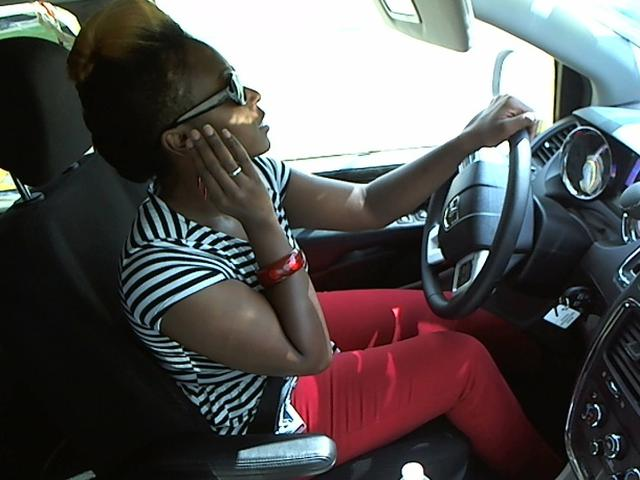

Prediction: hair and makeup


In [14]:
test_image_index = 3
display(Image(filename='/kaggle/input/state-farm-distracted-driver-detection/imgs/test/'+test_images[test_image_index]))
prediction = 'c' + str(np.argmax(test_predictions[test_image_index]))
print('Prediction:', classes[prediction])

In [15]:
pred_df = pd.DataFrame(columns = ['img','c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
for i in range(len(test_predictions)):
    pred_df.loc[i, 'img'] = test_images[i]
    pred_df.loc[i, 'c0':'c9'] = test_predictions[i]
pred_df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.0,0.000085,0.000469,0.000692,0.000001,0.998504,0.000008,0.0,0.0,0.000241
1,img_10.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,img_100.jpg,0.996367,0.000281,0.0,0.000049,0.000001,0.0,0.000037,0.000039,0.002308,0.000916
3,img_1000.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.999998,0.0
4,img_100000.jpg,0.000002,0.000344,0.000003,0.999595,0.000013,0.000004,0.0,0.0,0.000004,0.000034
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.000008,0.995514,0.001277,0.000002,0.000005,0.000001,0.000002,0.000965,0.00006,0.002165
79722,img_99995.jpg,0.00009,0.000218,0.000001,0.997429,0.000017,0.001116,0.001042,0.000002,0.0,0.000084
79723,img_99996.jpg,0.000035,0.000003,0.000022,0.001176,0.998268,0.000006,0.00012,0.000327,0.000034,0.000008
79724,img_99998.jpg,0.0,0.0,0.000003,0.000001,0.0,0.000018,0.999938,0.000001,0.00004,0.0


In [16]:
pred_df.to_csv('submission.csv', index=False)